# Tutorial 5 - FOSWEC
The goal of this tutorial is to show a design problem for a bottom-hinged oscillating-surge WEC.
The WEC in this tutorial is a single, fixed-bottom flap of the floating oscillating-surge WEC (FOSWEC).

* SAND report: https://doi.org/10.2172/1717884
* Journal paper: https://doi.org/10.1016/j.energy.2021.122485
* YouTube video: https://youtu.be/OUxbaEC2K6Y

This tutorial introduces...

In [97]:
import autograd.numpy as np
import capytaine as cpy
from capytaine.io.meshio import load_from_meshio
import matplotlib.pyplot as plt
from scipy.optimize import brute
import pygmsh
import gmsh
import xarray as xr

import wecopttool as wot

## set colorblind-friendly colormap for plots
plt.style.use('tableau-colorblind10')

## Experimental validation
During the testing campaign for the FOSWEC, a number of trials were run while providing white noise inputs to the generator at the hinge of each flap.
The base of the FOSWEC was kept fixed for these tests.
The white noise inputs and the WEC reponse allowed for the understanding of the excitation and the impedance associated with the aft and bow flaps.
To establish a reliable model, a fixed FOSWEC is modeled below and compared to the impedance from the experiment.

#### Load Impedance
First, we can load in the impedance data which has been calculated based on the white noise runs.

In [98]:
datafile = 'data/FOSWEC_empirical_data.nc'
empirical_data = xr.load_dataset(datafile)

f_vec_exp = empirical_data['omega']/(2*np.pi)
Zi_data_exp = empirical_data.Zi_data_real + 1j*empirical_data.Zi_data_imag

#### Hydrostatic stiffness
Among the experiments completed in the wave tank included gradually ramping up the torque applied by the generator to determine the relationship between torque on the flap and the resultant position.
These tests were performed without any wave conditions.
The relationship between the torque and position of the flap reveals the hydrostatic stiffness.
The experiments were performed on one flap but the hydrostatic stiffness should be the same for both because they are identical.
We do it linearly here, but nonlinearly later....

Text(0, 0.5, 'Torque (Nm)')

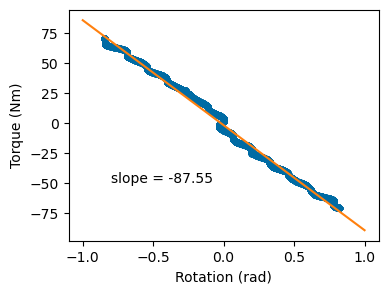

In [99]:
# load in data from ramps experiments
datafile = 'data/FOSWEC_ramps.nc'
ramps_data = xr.load_dataset(datafile)

# fit a linear curve
coefficients = np.polyfit(ramps_data['position'], ramps_data['torque'], 1)
pos_fitted = np.linspace(-1,1,100)
torque_fitted = np.polyval(coefficients, pos_fitted)

plt.figure(figsize=(4,3))
plt.plot(ramps_data['position'], ramps_data['torque'],'.')
plt.plot(pos_fitted,torque_fitted,'-')
plt.text(-0.8, -50, f'slope = {round(coefficients[0],2)}')
plt.xlabel('Rotation (rad)')
plt.ylabel('Torque (Nm)')

#### FOSWEC Geometry
The FOSWEC geometry is intended to be the same as from the experiments. 
Inputs to the function used to create the FOSWEC FloatingBody are the draft (uncertain from experiments) and hydrostatic coefficient (from ramps data above).
By testing a few values for the flap draft and comparing to the impedance data, we can determine a draft value which achieves a good match between the BEM data and empirical impedance.

In [100]:
def fixed_FOSWEC(draft, hs_coeff):

    # parameters from experiments
    flap_height = 0.58 
    flap_draft = draft
    flap_freeboard = flap_height - flap_draft
    flap_width = 0.76
    flap_thickness_bottom = 0.05
    flap_thickness_top = 0.12
    hinge_location = -flap_draft - .046
    mass = 23.1
    pitch_inertia_about_cg = 1.19
    z_cg_from_bottom = 0.17
    z_cg = -flap_draft + z_cg_from_bottom
    distance_between_flaps = 1.28

    mesh_size_factor = 0.2 # appropriate mesh size to avoid frequency spikes

    # mesh 1st flap
    with pygmsh.geo.Geometry() as geom:
        gmsh.option.setNumber('Mesh.MeshSizeFactor', mesh_size_factor)
        flap_poly = geom.add_polygon(
                [[-flap_thickness_bottom/2, -flap_width/2, -flap_draft],
                [flap_thickness_bottom/2, -flap_width/2, -flap_draft],
                [flap_thickness_top/2, -flap_width/2, flap_freeboard],
                [-flap_thickness_top/2, -flap_width/2, flap_freeboard]],mesh_size=mesh_size_factor)
        geom.extrude(flap_poly,[0,flap_width,0])
        flap_mesh = geom.generate_mesh()

    # mesh 2nd flap
    with pygmsh.geo.Geometry() as geom:
        gmsh.option.setNumber('Mesh.MeshSizeFactor', mesh_size_factor)
        flap_poly2 = geom.add_polygon(
                [[-flap_thickness_bottom/2 + distance_between_flaps, -flap_width/2, -flap_draft],
                [flap_thickness_bottom/2 + distance_between_flaps, -flap_width/2, -flap_draft],
                [flap_thickness_top/2 + distance_between_flaps, -flap_width/2, flap_freeboard],
                [-flap_thickness_top/2 + distance_between_flaps, -flap_width/2, flap_freeboard]],mesh_size=mesh_size_factor)
        geom.extrude(flap_poly2,[0,flap_width,0])
        flap_mesh2 = geom.generate_mesh()

    # add degrees of freedom for rotation around bottom hinge
    flap1_fb = cpy.FloatingBody(flap_mesh, name='flap_bow', center_of_mass=(0, 0, z_cg))
    axis1 = cpy.Axis(vector=(0, 1, 0), point=(0, 0, hinge_location))
    flap1_fb.add_rotation_dof(axis = axis1, name="pitch_bow_hinge") # used for BEM
    flap1_fb.rotation_center = (0, 0, hinge_location) # rotation center hydrostatics if not defined manually
    flap1_fb.keep_immersed_part() # keep immersed part should be run on each body separately before combining!

    flap2_fb = cpy.FloatingBody(flap_mesh2, name='flap_aft', center_of_mass=(distance_between_flaps, 0, z_cg))
    axis2 = cpy.Axis(vector=(0, 1, 0), point=(distance_between_flaps, 0, hinge_location))
    flap2_fb.add_rotation_dof(axis = axis2, name="pitch_aft_hinge")
    flap2_fb.rotation_center = (distance_between_flaps, 0, hinge_location)
    flap2_fb.keep_immersed_part() 

    foswec_fb = flap1_fb + flap2_fb

    # use parallel axis theorem to move inertia to base
    pitch_inertia_about_base = pitch_inertia_about_cg + mass*(z_cg - hinge_location)
    rigid_inertia_matrix_xr = xr.DataArray(data=np.diag([pitch_inertia_about_base, pitch_inertia_about_base]),
                                dims=['influenced_dof', 'radiating_dof'],
                                coords={'influenced_dof': list(foswec_fb.dofs),
                                        'radiating_dof': list(foswec_fb.dofs)},
                                name="inertia_matrix")
    foswec_fb.inertia_matrix = rigid_inertia_matrix_xr

    stiffness_matrix_xr = xr.DataArray(data=np.diag([np.squeeze(hs_coeff), np.squeeze(hs_coeff)]),
                                dims=['influenced_dof', 'radiating_dof'],
                                coords={'influenced_dof': list(foswec_fb.dofs),
                                        'radiating_dof': list(foswec_fb.dofs)},
                                name="hydrostatic_stiffness")
    foswec_fb.hydrostatic_stiffness = stiffness_matrix_xr

    return foswec_fb

### Check Rotation
To make sure the flap is rotating about the correct point, we can use Capytaine's animation features.
Open the `FOSWEC.mp4` file to check that both flaps are rotating about their respective hinges.

In [101]:
foswec_fb = fixed_FOSWEC(0.53, -coefficients[0])

# Create the animation
animation = foswec_fb.animate(motion={i: 0.5 for i in foswec_fb.dofs.keys()}, loop_duration=4.0)
animation.save('FOSWEC.mp4', nb_loops=4, camera_position=(-4, -4, 4), resolution=(800, 800))

### Tune Model Variables
While the model has been parameterized to the best of our ability, some uncertainty remains in terms of a couple variables:

* draft - The flaps were close to fully immersed during the experiments, but the exact draft value was not measured.
* friction - Because the torque used to calculate the empirical impedance is the generator torque, friction from the mechanical drivetrain and generator are included in the resultant impedance.

Ideally, these would have been discreetly measured during the experiments, but we can still use the measured impedance to determine relatively accurate valyes for the draft and friction.
Below, we plot the empirical impedance and the impedance derived from BEM while varying the draft and friction.
By comparing the impedance (rather than time-domain results), we can evaluate the hydrodynamics directly across a range of relevant frequencies.
While the plots below are a bit busy, there are a few valuable takeaways that are applicable to both flaps:

- The draft primarily impacts the frequency at which the trough of impedance is found. This means that the draft changes the mechanical natural frequency of the flap. 
- The friction primarily impacts the depth of the trough of impedance. This means the friction is changing the magnitude of the flap's response near the mechanical natural frequency.

By comparing the BEM data to the empirical impedance data, it is clear that the following values provide a relatively accurate model for the fixed-bottom FOSWEC.

* draft - 0.53 m
* friction - 12 Ns/rad

(-100.0, 100.0)

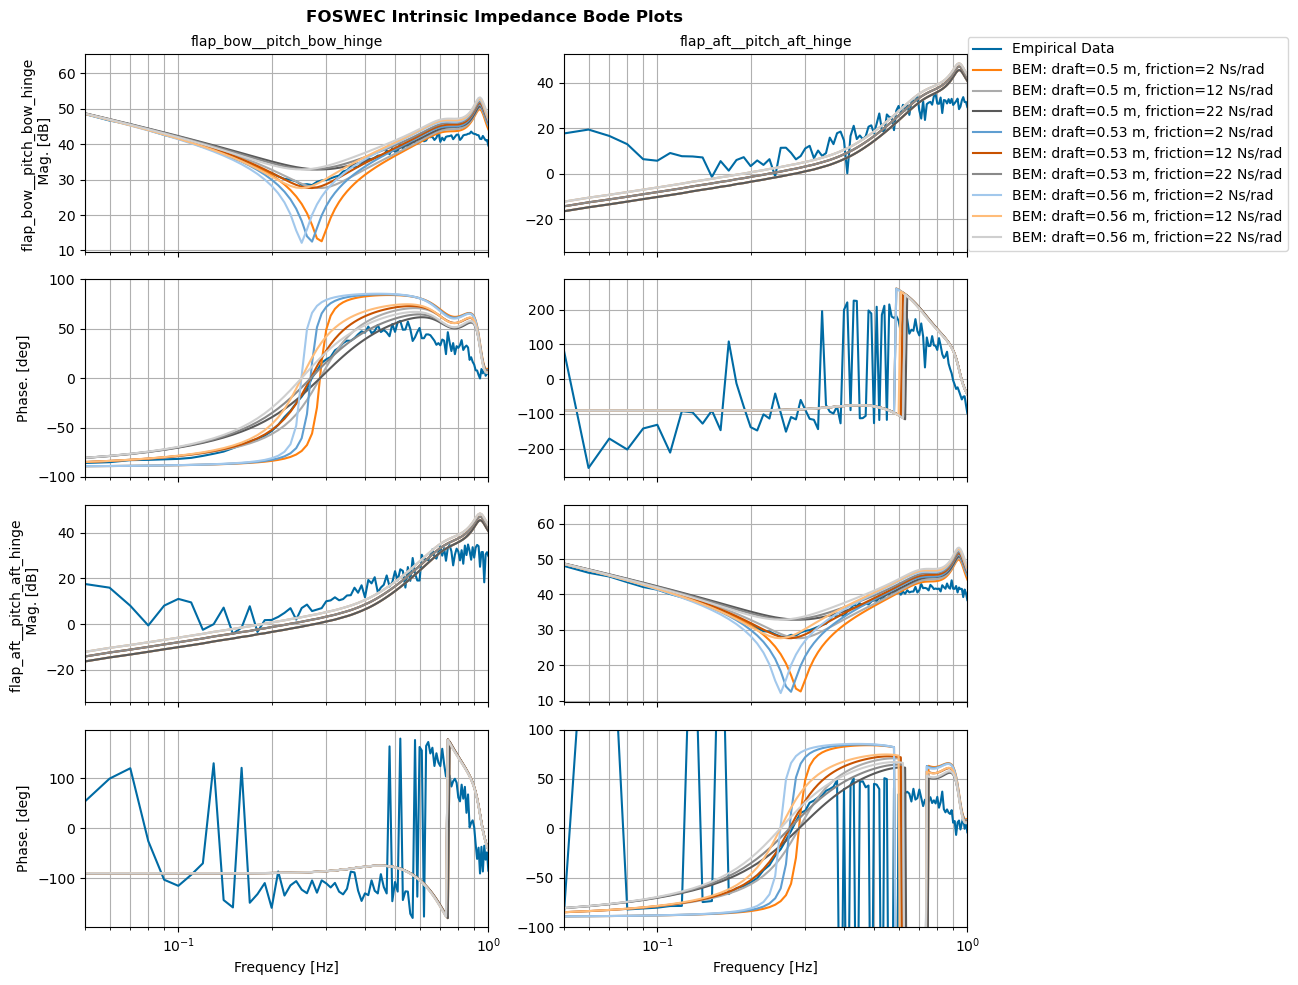

In [102]:
draft_check = np.linspace(0.5, 0.56, 3) 
friction_check = np.linspace(2, 22, 3)

f1 = .01
nfreq = 100
freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency

fig, axes = wot.utilities.plot_bode_impedance(Zi_data_exp,'FOSWEC Intrinsic Impedance')

labels = []

for draft in draft_check:
    foswec_fb = fixed_FOSWEC(draft, -coefficients[0])
    #foswec_fb.show_matplotlib()

    filename = f'data/FOSWEC_bem_{round(draft,2)}draft.nc'
    try:
        bem_data = wot.read_netcdf(filename)
    except:
        bem_data = wot.run_bem(foswec_fb, freq)
        wot.write_netcdf(filename, bem_data)

    for friction in friction_check:
        friction_mat = friction*np.diag((2,2))
        hd = wot.add_linear_friction(bem_data, friction = friction_mat) 
        hd = wot.check_radiation_damping(hd)
        Zi_bem = wot.hydrodynamic_impedance(hd)
        fig, axes = wot.utilities.plot_bode_impedance(Zi_bem, 'FOSWEC Intrinsic Impedance', fig_axes=[fig, axes])
        
        labels.append(f'BEM: draft={draft} m, friction={friction:.0f} Ns/rad')

fig.set_size_inches(10, 10)
fig.legend(np.append('Empirical Data',labels), bbox_to_anchor=(1.3, 0.96))
axes[0,0].set_xlim([0.05,1])
axes[1,0].set_ylim([-100, 100])
axes[3,1].set_ylim([-100, 100])

## Single Flap Design Study
Because the hydrodynamics are so similar between both flaps of the FOSWEC (as evidenced by impedance plots above), we can simplify the design study to consider just one flap.
Results from the study should be applicable to both flaps. 


### Wave Conditions
Here, we define the wave conditions to select a proper frequency vector.
Because this study is only for regular waves, the fundamental frequency can be equal to the wave frequency and we only need about 12 frequencies total to capture all nonlinearities.

In [103]:
period = 8 # s
wavefreq = 1/period # Hz
amplitude = 1 # m
phase = 0 # degrees
wavedir = 0 # degrees

f1 = wavefreq
nfreq = 12

waves = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude, phase, wavedir)
freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency

### Design Loop
The design loop here includes the tuned variables from above (draft and friction) as well as the center of gravity vertical location and rated generator power.
This enables a study which considers the impacts of changing the center of gravity of the flap (without altering the total mass) and using generators with different power ratings.

In [104]:
def one_flap_FOSWEC(draft, hs_coeff, z_cg_from_bottom, rated_power):

    # parameters from experiments
    flap_height = 0.58 
    flap_draft = draft
    flap_freeboard = flap_height - flap_draft
    flap_width = 0.76
    flap_thickness_bottom = 0.05
    flap_thickness_top = 0.12
    hinge_location = -flap_draft - .046
    mass = 23.1
    pitch_inertia_about_cg = 1.19
    z_cg_from_bottom = z_cg_from_bottom
    z_cg = -flap_draft + z_cg_from_bottom

    mesh_size_factor = 0.2 # appropriate mesh size to avoid frequency spikes

    # mesh 1st flap
    with pygmsh.geo.Geometry() as geom:
        gmsh.option.setNumber('Mesh.MeshSizeFactor', mesh_size_factor)
        flap_poly = geom.add_polygon(
                [[-flap_thickness_bottom/2, -flap_width/2, -flap_draft],
                [flap_thickness_bottom/2, -flap_width/2, -flap_draft],
                [flap_thickness_top/2, -flap_width/2, flap_freeboard],
                [-flap_thickness_top/2, -flap_width/2, flap_freeboard]],mesh_size=mesh_size_factor)
        geom.extrude(flap_poly,[0,flap_width,0])
        flap_mesh = geom.generate_mesh()

    # add degrees of freedom for rotation around bottom hinge
    flap_fb = cpy.FloatingBody(flap_mesh, name='flap_bow', center_of_mass=(0, 0, z_cg))
    axis = cpy.Axis(vector=(0, 1, 0), point=(0, 0, hinge_location))
    flap_fb.add_rotation_dof(axis = axis, name="pitch_bow_hinge") # used for BEM
    flap_fb.rotation_center = (0, 0, hinge_location) # rotation center hydrostatics if not defined manually
    flap_fb.keep_immersed_part()

    # use parallel axis theorem to move inertia to base
    pitch_inertia_about_base = pitch_inertia_about_cg + mass*(z_cg - hinge_location)
    rigid_inertia_matrix_xr = xr.DataArray(data=pitch_inertia_about_base,
                                dims=['influenced_dof', 'radiating_dof'],
                                coords={'influenced_dof': list(flap_fb.dofs),
                                        'radiating_dof': list(flap_fb.dofs)},
                                name="inertia_matrix")
    flap_fb.inertia_matrix = rigid_inertia_matrix_xr

    stiffness_matrix_xr = xr.DataArray(data=hs_coeff,
                                dims=['influenced_dof', 'radiating_dof'],
                                coords={'influenced_dof': list(flap_fb.dofs),
                                        'radiating_dof': list(flap_fb.dofs)},
                                name="hydrostatic_stiffness")
    flap_fb.hydrostatic_stiffness = stiffness_matrix_xr

    bem_data = wot.run_bem(flap_fb, freq) ## PTO impedance definition
    omega = bem_data.omega.values
    gear_ratio = 3.75
    torque_constant = 6.7
    winding_resistance = 0.5
    winding_inductance = 0
    drivetrain_inertia = 0
    drivetrain_friction = 0
    drivetrain_stiffness = 0

    drivetrain_impedance = (1j*omega*drivetrain_inertia + 
                            drivetrain_friction + 
                            1/(1j*omega)*drivetrain_stiffness) 

    winding_impedance = winding_resistance + 1j*omega*winding_inductance


    pto_impedance_11 = -1* gear_ratio**2 * drivetrain_impedance
    off_diag = np.sqrt(3.0/2.0) * torque_constant * gear_ratio
    pto_impedance_12 = -1*(off_diag+0j) * np.ones(omega.shape) 
    pto_impedance_21 = -1*(off_diag+0j) * np.ones(omega.shape)
    pto_impedance_22 = winding_impedance
    pto_impedance = np.array([[pto_impedance_11, pto_impedance_12],
                            [pto_impedance_21, pto_impedance_22]])

    ## Update PTO
    name = ['PTO_Pitch']
    kinematics = np.eye(1)
    pto_ndof = 1
    controller = None # unstructured controller
    loss = None
    pto = wot.pto.PTO(pto_ndof, kinematics, controller, pto_impedance, loss, name)

    # PTO dynamics forcing function
    f_add = {'PTO': pto.force_on_wec}

    # Constraint
    pos_max = 25*np.pi/180
    rms_max = rated_power
    nsubsteps = 4

    def const_pos_pto(wec, x_wec, x_opt, waves):
        pos = pto.position(wec, x_wec, x_opt, waves, nsubsteps) # computed pto position is the same as wec position
        return pos_max - np.abs(pos.flatten())

    def const_rms_power_pto(wec, x_wec, x_opt, waves):
        power = pto.power(wec, x_wec, x_opt, waves, nsubsteps)
        return rms_max - np.sqrt(np.mean(power**2))

    constraints = [{'type': 'ineq', 'fun': const_pos_pto}, {'type': 'ineq', 'fun': const_rms_power_pto}] 

    wec = wot.WEC.from_bem(bem_data,
                            constraints=constraints,
                            friction=12*np.eye(1), # tuned variable
                            f_add=f_add,)

    return wec, pto

In [105]:
cg_vals = np.linspace(0.04,0.4,3) # distance above bottom
rms_vals = np.linspace(2,16,8)

# Update objective function
nstate_opt = 2*nfreq

# Solve
scale_x_wec = 1e1
scale_x_opt = 1e-1
scale_obj = 1e-1

options = {'maxiter': 400}

nsubsteps = 4
num_runs = len(cg_vals)*len(rms_vals)
results_data = xr.Dataset(data_vars=dict(elec_power=(["cg","rms"], np.zeros((len(cg_vals),len(rms_vals)))), 
                                         capacity_factor=(["cg","rms"], np.zeros((len(cg_vals),len(rms_vals)))), 
                                         max_pitch_flap=(["cg","rms"], np.zeros((len(cg_vals),len(rms_vals)))), 
                                         max_torque_pto=(["cg","rms"], np.zeros((len(cg_vals),len(rms_vals)))), 
                                         max_power=(["cg","rms"], np.zeros((len(cg_vals),len(rms_vals)))),
                                         cg_recorded=(["cg","rms"], np.zeros((len(cg_vals),len(rms_vals)))),
                                         rms_recorded=(["cg","rms"], np.zeros((len(cg_vals),len(rms_vals),)))),  
                                         coords=dict(cgs=("cg",cg_vals), rmss=("rms",rms_vals)))

for cg_ind, cg in enumerate(cg_vals):
    for rms_ind, rms in enumerate(rms_vals):
        wec, pto = one_flap_FOSWEC(0.53,-coefficients[0], cg,rms)
        obj_fun = pto.average_power
            
        results = wec.solve(
            waves, 
            obj_fun, 
            nstate_opt, 
            optim_options=options, 
            scale_x_wec=scale_x_wec,
            scale_x_opt=scale_x_opt,
            scale_obj=scale_obj,
        )

        results_data['cg_recorded'][cg_ind,rms_ind] = cg
        results_data['rms_recorded'][cg_ind,rms_ind] = rms
        results_data['elec_power'][cg_ind,rms_ind] = results[0].fun
        results_data['capacity_factor'][cg_ind,rms_ind] = -results[0].fun/rms
        
        wec_fdom, wec_tdom = wec.post_process(wec, results, waves, nsubsteps=nsubsteps)
        pto_fdom, pto_tdom = pto.post_process(wec, results, waves, nsubsteps=nsubsteps)

        results_data['max_pitch_flap'][cg_ind,rms_ind] = max(wec_tdom[0]['pos'][0]).values
        results_data['max_torque_pto'][cg_ind,rms_ind] = max(pto_tdom[0]['force']).values.squeeze()
        results_data['max_power'][cg_ind,rms_ind] = max(pto_tdom[0]['power'].loc['elec',:,:]).values.squeeze()

[14:49:42] WARNING  center_of_mass already defined as [ 0.    0.   -0.49].

           WARNING  rotation_center already defined as (0, 0, -0.5760000000000001).

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\wecopttool\core.py:759: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.19200073911391302
            Iterations: 61
            Function evaluations: 62
            Gradient evaluations: 61


[14:49:58] WARNING  center_of_mass already defined as [ 0.    0.   -0.49].

           WARNING  rotation_center already defined as (0, 0, -0.5760000000000001).

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\wecopttool\core.py:759: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.3845026763084878
            Iterations: 72
            Function evaluations: 73
            Gradient evaluations: 72


[14:50:14] WARNING  center_of_mass already defined as [ 0.    0.   -0.49].

           WARNING  rotation_center already defined as (0, 0, -0.5760000000000001).

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\wecopttool\core.py:759: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.5608842787565614
            Iterations: 50
            Function evaluations: 51
            Gradient evaluations: 50


[14:50:27] WARNING  center_of_mass already defined as [ 0.    0.   -0.49].

           WARNING  rotation_center already defined as (0, 0, -0.5760000000000001).

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\wecopttool\core.py:759: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.6609714872765836
            Iterations: 46
            Function evaluations: 47
            Gradient evaluations: 46


[14:50:40] WARNING  center_of_mass already defined as [ 0.    0.   -0.49].

           WARNING  rotation_center already defined as (0, 0, -0.5760000000000001).

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\wecopttool\core.py:759: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.716017086942256
            Iterations: 35
            Function evaluations: 36
            Gradient evaluations: 35


[14:50:52] WARNING  center_of_mass already defined as [ 0.    0.   -0.49].

           WARNING  rotation_center already defined as (0, 0, -0.5760000000000001).

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\wecopttool\core.py:759: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7270501383083127
            Iterations: 34
            Function evaluations: 35
            Gradient evaluations: 34


[14:51:04] WARNING  center_of_mass already defined as [ 0.    0.   -0.49].

           WARNING  rotation_center already defined as (0, 0, -0.5760000000000001).

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\wecopttool\core.py:759: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7270499658131816
            Iterations: 35
            Function evaluations: 35
            Gradient evaluations: 35


[14:51:15] WARNING  center_of_mass already defined as [ 0.    0.   -0.49].

           WARNING  rotation_center already defined as (0, 0, -0.5760000000000001).

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\wecopttool\core.py:759: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7270538778018165
            Iterations: 37
            Function evaluations: 37
            Gradient evaluations: 37


[14:51:28] WARNING  center_of_mass already defined as [ 0.    0.   -0.31].

           WARNING  rotation_center already defined as (0, 0, -0.5760000000000001).

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\wecopttool\core.py:759: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.19247189894001748
            Iterations: 80
            Function evaluations: 81
            Gradient evaluations: 80


[14:51:45] WARNING  center_of_mass already defined as [ 0.    0.   -0.31].

           WARNING  rotation_center already defined as (0, 0, -0.5760000000000001).

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\wecopttool\core.py:759: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.38435546859115993
            Iterations: 174
            Function evaluations: 287
            Gradient evaluations: 174


[14:52:14] WARNING  center_of_mass already defined as [ 0.    0.   -0.31].

           WARNING  rotation_center already defined as (0, 0, -0.5760000000000001).

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\wecopttool\core.py:759: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.5625963201573524
            Iterations: 60
            Function evaluations: 61
            Gradient evaluations: 60


[14:52:29] WARNING  center_of_mass already defined as [ 0.    0.   -0.31].

           WARNING  rotation_center already defined as (0, 0, -0.5760000000000001).

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\wecopttool\core.py:759: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.6634521646957504
            Iterations: 39
            Function evaluations: 40
            Gradient evaluations: 39


[14:52:42] WARNING  center_of_mass already defined as [ 0.    0.   -0.31].

           WARNING  rotation_center already defined as (0, 0, -0.5760000000000001).

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\wecopttool\core.py:759: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7181857607661226
            Iterations: 40
            Function evaluations: 40
            Gradient evaluations: 40


[14:52:55] WARNING  center_of_mass already defined as [ 0.    0.   -0.31].

           WARNING  rotation_center already defined as (0, 0, -0.5760000000000001).

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\wecopttool\core.py:759: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.728442455977667
            Iterations: 37
            Function evaluations: 38
            Gradient evaluations: 37


[14:53:07] WARNING  center_of_mass already defined as [ 0.    0.   -0.31].

           WARNING  rotation_center already defined as (0, 0, -0.5760000000000001).

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\wecopttool\core.py:759: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.72843797501101
            Iterations: 29
            Function evaluations: 30
            Gradient evaluations: 29


[14:53:18] WARNING  center_of_mass already defined as [ 0.    0.   -0.31].

           WARNING  rotation_center already defined as (0, 0, -0.5760000000000001).

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\wecopttool\core.py:759: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7284420264634917
            Iterations: 36
            Function evaluations: 36
            Gradient evaluations: 36


[14:53:31] WARNING  center_of_mass already defined as [ 0.    0.   -0.13].

           WARNING  rotation_center already defined as (0, 0, -0.5760000000000001).

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\wecopttool\core.py:759: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.19242832026629658
            Iterations: 63
            Function evaluations: 64
            Gradient evaluations: 63


[14:53:47] WARNING  center_of_mass already defined as [ 0.    0.   -0.13].

           WARNING  rotation_center already defined as (0, 0, -0.5760000000000001).

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\wecopttool\core.py:759: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.3851322771782544
            Iterations: 103
            Function evaluations: 111
            Gradient evaluations: 103


[14:54:08] WARNING  center_of_mass already defined as [ 0.    0.   -0.13].

           WARNING  rotation_center already defined as (0, 0, -0.5760000000000001).

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\wecopttool\core.py:759: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.5640509089765183
            Iterations: 57
            Function evaluations: 58
            Gradient evaluations: 57


[14:54:31] WARNING  center_of_mass already defined as [ 0.    0.   -0.13].

           WARNING  rotation_center already defined as (0, 0, -0.5760000000000001).

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\wecopttool\core.py:759: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.6656499468668335
            Iterations: 46
            Function evaluations: 47
            Gradient evaluations: 46


[14:54:47] WARNING  center_of_mass already defined as [ 0.    0.   -0.13].

           WARNING  rotation_center already defined as (0, 0, -0.5760000000000001).

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\wecopttool\core.py:759: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.720024627096115
            Iterations: 36
            Function evaluations: 37
            Gradient evaluations: 36


[14:55:02] WARNING  center_of_mass already defined as [ 0.    0.   -0.13].

           WARNING  rotation_center already defined as (0, 0, -0.5760000000000001).

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\wecopttool\core.py:759: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7295802311449843
            Iterations: 37
            Function evaluations: 37
            Gradient evaluations: 37


[14:55:16] WARNING  center_of_mass already defined as [ 0.    0.   -0.13].

           WARNING  rotation_center already defined as (0, 0, -0.5760000000000001).

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\wecopttool\core.py:759: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7295805875348697
            Iterations: 36
            Function evaluations: 36
            Gradient evaluations: 36


[14:55:28] WARNING  center_of_mass already defined as [ 0.    0.   -0.13].

           WARNING  rotation_center already defined as (0, 0, -0.5760000000000001).

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\wecopttool\core.py:759: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7295801199240253
            Iterations: 36
            Function evaluations: 37
            Gradient evaluations: 36


### Results


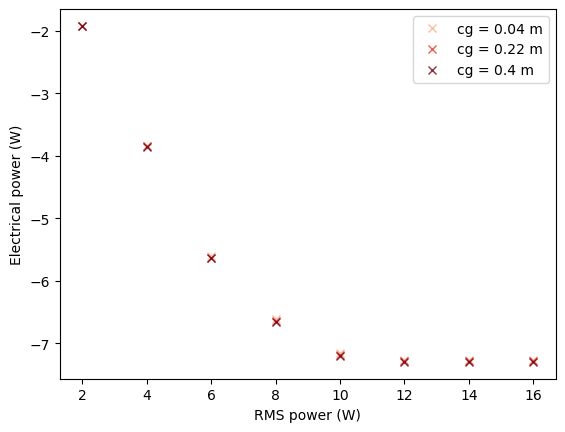

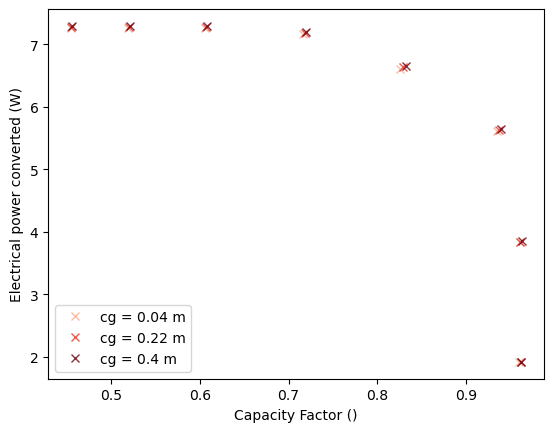

In [107]:
colors = plt.cm.Reds(np.linspace(0.3,1,len(results_data['cgs'])))

plt.figure()
for ind, cg in enumerate(results_data['cgs']):
    results_cg = results_data.where(results_data.cgs == cg, drop=True)

    plt.plot(results_cg['rmss'], results_cg['elec_power'].squeeze(),'x',label=f'cg = {np.round(cg.values,2)} m',alpha=0.8,color=colors[ind])
    plt.xlabel('RMS power (W)')
    plt.ylabel('Electrical power (W)')
plt.legend()

plt.figure()
for ind, cg in enumerate(results_data['cgs']):
    results_cg = results_data.where(results_data.cgs == cg, drop=True)

    plt.plot(results_cg['capacity_factor'].squeeze(), -results_cg['elec_power'].squeeze(),'x',label=f'cg = {np.round(cg.values,2)} m',alpha=0.8,color=colors[ind])
    plt.xlabel('Capacity Factor ()')
    plt.ylabel('Electrical power converted (W)')
plt.legend()